# Exploring the loan data from online lending platform: Lending Club. 
Three machine learning methods were evaluated:
- Logistic regression, 
- linear SVM, 
- Gradient Boosting.

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import preprocessing as skp
from sklearn import ensemble, metrics, svm, pipeline
from sklearn import linear_model as sklm
from sklearn import model_selection as skms
from sklearn import feature_selection as skfs
from sklearn import neural_network as skn
%matplotlib inline

Dataset available at: https://www.kaggle.com/wendykan/lending-club-loan-data

In [2]:
df=pd.read_csv('../lending_club/lending-club-loan-data/loan.csv', index_col=0)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_orig=df.copy()

In [4]:
df.shape

(887379, 73)

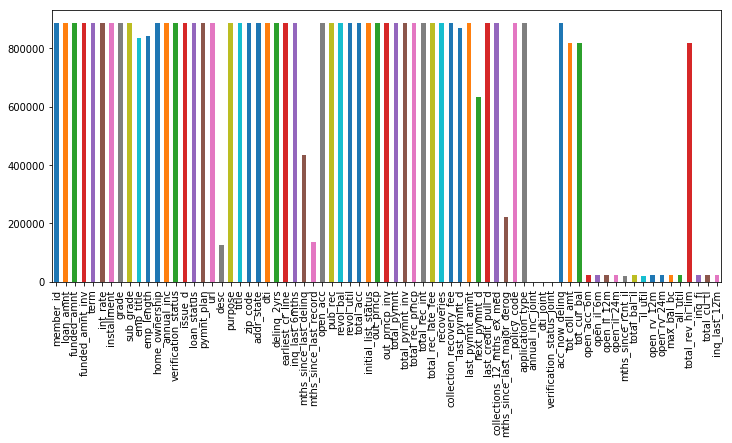

In [5]:
df.count().plot.bar(figsize=(12,5))

In [6]:
df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [7]:
df.dtypes

member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line         

Create new features to indicate if there are joint applicants and if not, duplicate the value from sole applicant's data.

In [26]:
for col in ['annual_inc', 'dti']:
    has_joint=~pd.isnull(df[col+'_joint'])
    df[col+'_has_joint']=has_joint.astype(bool)
    df.loc[has_joint[has_joint==False].index, col+'_joint']=df.loc[has_joint[has_joint==False].index, col]

In [30]:
df[['dti_has_joint', 'annual_inc_has_joint']].dtypes

dti_has_joint           bool
annual_inc_has_joint    bool
dtype: object

In [27]:
df.annual_inc_has_joint.head()

id
1077501    False
1077430    False
1077175    False
1076863    False
1075358    False
Name: annual_inc_has_joint, dtype: bool

In [10]:
df.pub_rec.describe()

count    887350.000000
mean          0.195307
std           0.582091
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          86.000000
Name: pub_rec, dtype: float64

In [11]:
df[df.mths_since_last_major_derog==0]['pub_rec'].value_counts()

0.0    117
1.0     28
2.0      6
4.0      1
3.0      1
Name: pub_rec, dtype: int64

In [12]:
df[df.pub_rec==0]['mths_since_last_major_derog'].head()

id
1077501   NaN
1077430   NaN
1077175   NaN
1076863   NaN
1075358   NaN
Name: mths_since_last_major_derog, dtype: float64

In [17]:
df['derog_score']=(1/df.mths_since_last_major_derog.replace(to_replace=0, value=1)).fillna(value=1) * df.pub_rec.fillna(value=0)

In [18]:
df.index[~np.isfinite(df['derog_score'])]

Int64Index([], dtype='int64', name='id')

In [19]:
lack_of_data_cols = df.columns[df.count() < df.shape[0]*0.25]

In [20]:
lack_of_data_cols

Index(['desc', 'mths_since_last_record', 'mths_since_last_major_derog',
       'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
       'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util',
       'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi',
       'total_cu_tl', 'inq_last_12m'],
      dtype='object')

In [33]:
continuous_features=df.columns[(df.dtypes=='float')|(df.dtypes=='int')]

In [34]:
continuous_features

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m'],
      dtype='object')

In [35]:
#df.mths_since_last_delinq.fillna(value=31, inplace=True)
imputer=skp.Imputer(strategy='median', axis=0)
df[df.columns[df.dtypes!='object']]=imputer.fit_transform(df[df.columns[df.dtypes!='object']])

In [36]:
lack_of_data_cols=df.columns[df.count() < df.shape[0]*0.25]
print(lack_of_data_cols)

Index(['desc', 'verification_status_joint'], dtype='object')


In [37]:
# Hot encode some categorical features 
cat_cols = ['term', 'grade', 'sub_grade', 'emp_length', 'purpose', 'application_type','addr_state',
            'pymnt_plan', 'initial_list_status', 'home_ownership', 'verification_status']

for col in cat_cols:
    tmp_df = pd.get_dummies(df[col], prefix=col)
    df = pd.concat((df, tmp_df), axis=1)

In [38]:
'''(df.loan_status == 'Fully Paid') |
                        (df.loan_status == 'Current') | 
                        (df.loan_status == 'Does not meet the credit policy. Status:Fully Paid')'''

to_replace=['Fully Paid', 'Charged Off', 'Current', 'Default',
            'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
            'Does not meet the credit policy. Status:Fully Paid',
            'Does not meet the credit policy. Status:Charged Off', 'Issued']
new=[False, True, False, True, True, True, True, False, True, False]
df['loan_status_new']=df['loan_status'].replace(to_replace=to_replace, value=new)
df['loan_status_new'].value_counts()

False    819950
True      67429
Name: loan_status_new, dtype: int64

In [39]:
df['loan_status_new'].value_counts()/df['loan_status_new'].shape[0]

False    0.924013
True     0.075987
Name: loan_status_new, dtype: float64

In [161]:
df.to_csv('../lending_club/lending-club-loan-data/loan_MH.csv')

In [41]:
df_norm=df.copy()
df_norm[continuous_features]=stats.zscore(df[continuous_features].values)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:2248: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [42]:
df_norm.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,loan_status_new
id,,,,,,,,,,,,,,,,,,,,,
1077501,1296599.0,-1.156460,-1.155635,-1.152256,36 months,-0.592611,-1.121467,B,B2,NaN,...,0,0,0,0,0,1,0,0,1,False
1077430,1314167.0,-1.452829,-1.452198,-1.445430,60 months,0.461735,-1.543440,C,C4,Ryder,...,0,0,0,0,0,1,0,1,0,True
1077175,1313524.0,-1.464683,-1.464061,-1.457275,36 months,0.619202,-1.443107,C,C5,NaN,...,0,0,0,0,0,1,1,0,0,False
1076863,1277178.0,-0.563724,-0.562507,-0.557025,36 months,0.055515,-0.398905,C,C1,AIR RESOURCES BOARD,...,0,0,0,0,0,1,0,1,0,False
1075358,1311748.0,-1.393555,-1.392886,-1.386203,60 months,-0.127055,-1.510842,B,B5,University Medical Group,...,0,0,0,0,0,1,0,1,0,False


In [55]:
more_to_drop=['emp_title', 'issue_d', 'title', 'url', 'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d',
              'loan_status', 'loan_status_new', 'member_id', 'policy_code']
cols_to_drop=cat_cols+more_to_drop+lack_of_data_cols.tolist()+df.columns[df.dtypes=='object'].tolist()

feature_cols=df.columns
feature_cols=feature_cols.drop(cols_to_drop)
target_col='loan_status_new'

In [45]:
feature_cols.shape, feature_cols

((186,), Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
        'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
        'mths_since_last_delinq',
        ...
        'initial_list_status_w', 'home_ownership_ANY',
        'home_ownership_MORTGAGE', 'home_ownership_NONE',
        'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
        'verification_status_Not Verified',
        'verification_status_Source Verified', 'verification_status_Verified'],
       dtype='object', length=186))

In [56]:
X_train, X_test, y_train, y_test=skms.train_test_split(df_norm[feature_cols], df_norm[target_col], 
                                                       test_size=0.5, random_state=1, stratify=df_norm[target_col])

In [66]:
X_train.shape, y_train.shape, df_norm.shape

((443689, 185), (443689,), (887379, 211))

In [61]:
np.nonzero(np.isnan(X_train.values))

(array([], dtype=int64), array([], dtype=int64))

In [67]:
estimator=sklm.LogisticRegression(verbose=1, random_state=1)
selector=skfs.SelectFromModel(estimator)
selector.fit(X_train, y_train)

[LibLinear]

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [82]:
y_test.value_counts()

False    409975
True      33715
Name: loan_status_new, dtype: int64

In [69]:
feature_cols[selector.get_support()]

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'grade_A', 'grade_B',
       'grade_C', 'grade_E', 'grade_F', 'grade_G', 'sub_grade_B1',
       'sub_grade_E5', 'sub_grade_F4', 'sub_grade_F5', 'addr_state_ME',
       'addr_state_ND', 'pymnt_plan_n', 'pymnt_plan_y'],
      dtype='object')

In [87]:
clf=sklm.LogisticRegression(random_state=1)
#p=pipeline.Pipeline([('Feature_selection', selector), 
#                     ('Logit', clf)])
clf.fit(X_train, y_train)
pred=clf.predict(X_test)
print('AUC: %.3f' % metrics.roc_auc_score(y_test, pred))
print('Precision: %.3f' % metrics.precision_score(y_test, pred))
print('Recall: %.3f' % metrics.recall_score(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))

AUC: 0.835
Precision: 0.989
Recall: 0.671
[[409716    259]
 [ 11094  22621]]


In [79]:
estimator=sklm.LogisticRegression(random_state=1)
selector=skfs.SelectFromModel(estimator)
clf=sklm.LogisticRegression(random_state=1)
p=pipeline.Pipeline([('Feature_selection', selector), 
                     ('Logit', clf)])
p.fit(X_train, y_train)
pred=p.predict(X_test)
print('AUC: %.3f' % metrics.roc_auc_score(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))

AUC: 0.83
[[409941     34]
 [ 11403  22312]]


In [85]:
estimator=svm.LinearSVC(random_state=1)
selector=skfs.SelectFromModel(estimator)
clf=sklm.LogisticRegression(random_state=1)
p=pipeline.Pipeline([('Feature_selection', selector), 
                     ('Logit', clf)])
p.fit(X_train, y_train)
pred=p.predict(X_test)
print('AUC: %.3f' % metrics.roc_auc_score(y_test, pred))
print('Precision: %.3f' % metrics.precision_score(y_test, pred))
print('Recall: %.3f' % metrics.recall_score(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))

AUC: 0.830
[[409927     48]
 [ 11470  22245]]


In [86]:
estimator=svm.LinearSVC(random_state=1)
selector=skfs.SelectFromModel(estimator)
clf=svm.SVC(random_state=1)
p=pipeline.Pipeline([('Feature_selection', selector), 
                     ('svm_rbf', clf)])
p.fit(X_train, y_train)
pred=p.predict(X_test)
print('AUC: %.3f' % metrics.roc_auc_score(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))

AUC: 0.835
[[409843    132]
 [ 11093  22622]]


In [83]:
estimator=sklm.LogisticRegression(random_state=1)
selector=skfs.SelectFromModel(estimator)
clf=ensemble.GradientBoostingClassifier(min_samples_split=200)
p=pipeline.Pipeline([('Feature_selection', selector), 
                     ('GB', clf)])
p.fit(X_train, y_train)
pred=p.predict(X_test)
print('AUC: %.3f' % metrics.roc_auc_score(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))

AUC: 0.827
[[409933     42]
 [ 11683  22032]]


In [84]:
pred=p.predict(X_train)
print('AUC: %.3f' % metrics.roc_auc_score(y_train, pred))
print(metrics.confusion_matrix(y_train, pred))

AUC: 0.827
[[409942     33]
 [ 11638  22076]]
